In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

* Color is from (1, q)
* correct answer for energy has a factor 2
* magnetization computation
* how to show energy is distributed

In [2]:
#function to return LxL matrix with random/homogeneous states from 0 to q
def state_generator(q, L):
    if q != 1:
        return np.random.randint(1, q+1, (L,L))
    else:
        return np.ones((L,L), int)

In [3]:
def energy(state, coupling_const, ext_field):
    """"Computes the energy of a given configuration state by taking the following steps:
    A. Compute the 1st term of hamiltonian:
    Get the 4 neighbors for each s, since periodic boundary conditions are imposed. 
    Compare the value of s with each neighboring site using kronecker-delta fn: if values are equal, then value is 1, otherwise 0. 
    The total_nb_energy is the negative of the sum of the 4 kronecker-delta fn. The hamiltonian_1st is the product of coupling
    constant and total_nb_energy. 
    
    B. Compute the 2nd term of hamiltonian:
    Compare each s with value of 1, using kronecker-delta fn: if values are equal, then value is 1, otherwise 0.
    Multiply this by the ext_field and save it as hamiltonian_2nd. 
    
    Do A and B for each s across the LxL matrix.
    Energy of a given configuration is hamiltonian_1st - hamiltonian_2nd
    
    Args:
        state(np.array): LxL matrix of a configuration
        coupling_const(float): coupling constant
        ext_field(float): external magnetic field
        
    Returns:
        energy(float)
        
    """
    total_nb_energy = 0
    hamiltonian_2nd = 0
    lx, ly = state.shape
    for i_pair, s in np.ndenumerate(state):
        #get the 4 neighbors for each s
        nb1 = state[(i_pair[0], (i_pair[1]+1)%ly)]
        nb2 = state[(i_pair[0], (i_pair[1]-1)%ly)]
        nb3 = state[((i_pair[0]+1)%lx, i_pair[1])]
        nb4 = state[((i_pair[0]-1)%lx, i_pair[1])]
        #compute total neighbor energy
        total_nb_energy -= (np.array([nb1, nb2, nb3, nb4]) == s).sum()
        #calculate hamiltonian_1st
        hamiltonian_1st = coupling_const/2 * total_nb_energy
        
        #calculate hamiltonian_2nd
        if s == 1:            
            delta_h = 1
            hamiltonian_2nd += ext_field*delta_h
    return hamiltonian_1st - hamiltonian_2nd

In [4]:
#function to return the magnetization by computing the percentage of sites with s == 1
def magnetization(state):
    q_list = state.flatten()
    return (q_list == 1).sum()/state.size

In [5]:
coupling_const = 2
ext_field = 0.1

### Energy for different configuration of states

State with all s = 1

In [6]:
one_state = state_generator(1, 3)
one_state

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [7]:
one_energy = energy(one_state, coupling_const, ext_field)
one_energy

-36.9

In [8]:
#compare answer
N = one_state.size
one_energy_correct = -(coupling_const*N*2) - (N*ext_field)
one_energy_correct

-36.9

State with homogenous color s, except for s = 1

In [9]:
other_state = state_generator(1, 3)*2
other_state

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

In [10]:
other_energy = energy(other_state, coupling_const, ext_field)
other_energy

-36.0

In [11]:
#compare answer
N = other_state.size
other_energy_correct = -coupling_const*N*2
other_energy_correct

-36

### Magnetization for different configuration of states

In [12]:
#all s = 1
one_magnetization = magnetization(one_state)
one_magnetization

1.0

In [13]:
#homogenous color, except for s = 1
other_magnetization = magnetization(other_state)
other_magnetization

0.0

## Energy and magnetization for random states of 0 to q

In [14]:
q = 4
L = 5
random_state = state_generator(q, L)
random_state

array([[1, 1, 4, 4, 4],
       [4, 1, 3, 1, 1],
       [3, 1, 3, 2, 1],
       [3, 2, 2, 4, 3],
       [1, 4, 2, 4, 3]])

Energy

In [15]:
random_energy = energy(random_state, coupling_const, ext_field)
random_energy

-32.8

In [16]:
#correct answer
N = random_state.size
energy_random_correct = -(coupling_const*N*(2/q)) - (N*(ext_field/q))
energy_random_correct

-25.625

Magnetization

In [17]:
random_magnetization = magnetization(random_state)
random_magnetization

0.32

In [18]:
#correct answer
random_magnetization_correct = 1/q
random_magnetization_correct

0.25

Energy and magnetization distribution

In [19]:
%%time
n_realizations =1000
q = 2
L = 10
coupling_const = 2
ext_field = 0.1

energy_list = []
magnetization_list = []
for i in range(n_realizations):
    random_state = state_generator(q, L)
    random_energy = energy(random_state, coupling_const, ext_field)
    random_magnetization = magnetization(random_state)
    
    energy_list.append(random_energy)
    magnetization_list.append(random_magnetization)

Wall time: 695 ms


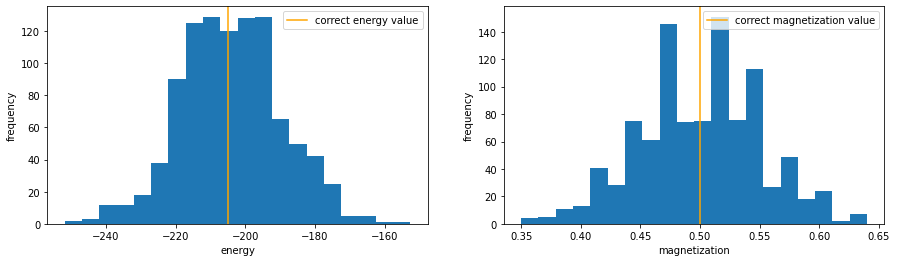

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

N = random_state.size
energy_correct = -(coupling_const*N*(2/q)) - (N*(ext_field/q))
magnetization_correct = 1/q

ax[0].hist(energy_list, bins=20)
ax[0].axvline(energy_correct, color = 'orange', label='correct energy value')
ax[0].set_xlabel('energy')
ax[0].set_ylabel('frequency')
ax[0].legend()

ax[1].hist(magnetization_list, bins=20)

ax[1].axvline(magnetization_correct, color = 'orange', label='correct magnetization value')
ax[1].set_xlabel('magnetization')
ax[1].set_ylabel('frequency')
ax[1].legend()
plt.show()

TODO: Different values of q for magnetization

* clarify histogram
* -1.9 is it correct
* what is J in the sanity check

## Metropolis Markov Chain

In [21]:
def delta_energy(state, state_prime, coupling_const, ext_field):
    state_energy = energy(state, coupling_const, ext_field)
    state_prime_energy = energy(state_prime, coupling_const, ext_field)
    return state_prime_energy - state_energy

In [22]:
state = np.array([[1, 2, 2],[2, 1, 1],[2, 1, 1]])
state_prime = np.array([[2, 2, 2],[2, 1, 1],[2, 1, 1]])
coupling_const = 1
ext_field = 0.1
delta_e = delta_energy(state, state_prime, coupling_const, ext_field)
delta_e

-3.9000000000000004

In [23]:
def metropolis_step(state, q, coupling_const, ext_field, beta):
    new_configuration = []
    
    lx, ly = state.shape
    flattened_state = state.flatten()
    #choose 1 element from the state
    chosen_index = np.random.randint(0,lx**2)    
    original_element = flattened_state[chosen_index]
    #choose random value of q
    new_element = np.random.randint(1,q+1)
    #change element to another color except itself
    while new_element == original_element:
        new_element = np.random.randint(1,q+1)
    #replace the original_element to the new_element
    flattened_state[chosen_index] = new_element
    new_state = flattened_state.reshape(lx, ly)
    #calculate energy:
    delta_e = delta_energy(state, new_state, coupling_const, ext_field)
    #condition
    if delta_e <= 0:
        new_configuration = new_state
    else:
        prob = np.exp(-beta*delta_e)
        unif = np.random.rand()
        if unif < prob:  
            new_configuration = new_state
        else:
            new_configuration = state
    return new_configuration

In [24]:
%%time
n_realizations = 10000
q = 2
L = 20
coupling_const = 1
ext_field = 0.1
beta = 10
state = state_generator(q, L)
print('orig state', state)
for i in range(n_realizations):    
    state = metropolis_step(state, q, coupling_const, ext_field, beta)
    if state.flatten().sum() == L**2:
        print('iterations', i)
        final_state = state
        break

print('final_state', final_state)

orig state [[2 2 1 2 2 2 2 1 1 2 2 1 2 1 1 2 1 1 2 1]
 [1 1 2 1 1 2 1 1 1 2 2 1 1 1 2 2 2 2 1 2]
 [1 1 1 2 2 2 2 1 1 2 2 1 1 1 1 1 1 1 2 2]
 [1 1 1 1 2 1 1 1 2 1 1 2 2 2 1 2 1 1 2 1]
 [2 2 2 2 2 1 2 1 2 2 1 2 2 2 2 1 2 2 2 2]
 [1 2 1 1 1 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2]
 [2 2 2 1 2 1 2 1 1 2 2 2 2 2 2 1 2 2 1 2]
 [2 2 2 2 2 1 2 1 2 1 2 1 1 1 1 1 2 1 2 1]
 [2 1 1 1 2 1 1 2 1 1 2 2 1 2 2 1 1 2 1 1]
 [1 2 1 1 2 2 1 1 2 2 2 1 1 2 2 2 2 2 1 1]
 [1 1 2 2 1 2 1 1 1 1 2 2 2 2 1 1 2 2 2 2]
 [1 1 2 2 2 2 2 1 1 2 1 1 1 2 1 2 1 1 1 2]
 [1 1 2 2 1 1 2 1 2 1 1 1 2 2 1 1 2 1 2 2]
 [2 2 2 2 1 2 2 2 2 1 1 2 1 2 1 2 1 2 1 2]
 [2 2 2 2 2 1 2 1 2 1 1 1 2 2 2 2 1 2 1 2]
 [2 2 2 2 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 1]
 [2 2 2 1 1 2 1 2 2 2 1 2 1 2 1 1 2 2 2 2]
 [2 2 1 1 2 1 2 2 2 1 1 2 1 1 1 2 2 1 2 2]
 [2 1 1 2 1 1 1 1 2 1 1 2 2 1 1 2 1 1 2 1]
 [1 1 2 2 1 2 1 1 2 1 1 1 1 1 2 2 2 2 2 1]]
iterations 4445
final_state [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 

## Generating samples and computing the magnetization

* is 2.2 correct: function that generates samples of energy and magnetization with
the Metropolis algorithm vs returns the list/array of the Nsamples generated samples.
* absolute magnetization, average is zero
* length of chain as L, L as size of matrix

In [25]:
def sample_generator(L, len_chain, beta, q, coupling_const, ext_field, equi_time, n_samples):
    state_list = []
    generated_samples = 0
    #generate a state
    state = state_generator(q, L)

    #generate states using metropolis step in burn-in time
    for i in range(len_chain):
        state = metropolis_step(state, q, coupling_const, ext_field, beta)

    state_list.append(state)
    generated_samples += 1
    
    #generate n_samples of states for each equi_time
    while generated_samples <= n_samples:

        #after reaching burn-in time, generate states using metropolis step within the equi time interval
        for j in range(equi_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)

        state_list.append(state)

        generated_samples += 1

    return state_list

In [26]:
sample_generator(3, 10, 10, 3, 2, 0.1, 10, 4)

[array([[1, 2, 1],
        [2, 2, 1],
        [1, 1, 1]]),
 array([[2, 2, 1],
        [1, 2, 1],
        [1, 1, 1]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])]

## Numerical Investigations

* meaning for N goes to inifnity

In [27]:
#different beta critical for each q
coupling_const = 1
q_list = [1,2,3,4,5,6]
for q in q_list:
    critical_beta = np.log(1+np.sqrt(q))/coupling_const
    print(q, critical_beta)

1 0.6931471805599453
2 0.8813735870195429
3 1.005052538742381
4 1.0986122886681098
5 1.1743590056195488
6 1.2382263194623326


In [28]:
#function to calculate single energy trajectory
def energy_trajectories(state, q, coupling_const, ext_field, beta, max_time):
    trajectory  = []
    for n in range(max_time):
        state = metropolis_step(state, q, coupling_const, ext_field, beta)
        one_energy = energy(state, coupling_const, ext_field)
        trajectory.append(one_energy)
    return trajectory

#function to calculate average energy trajectory
def average_energy_trajectories(state, q, coupling_const, ext_field, beta, max_time, n_realizations):
    average_trajectory = np.zeros(max_time)
    for r in range(n_realizations):
        trajectory = energy_trajectories(state, q, coupling_const, ext_field, beta, max_time)
        average_trajectory += np.array(trajectory)/n_realizations
    return average_trajectory

In [29]:
#function to calculate single magnetization trajectory
def magnetization_trajectories(state, q, coupling_const, ext_field, beta, max_time):
    trajectory  = []
    for n in range(max_time):
        state = metropolis_step(state, q, coupling_const, ext_field, beta)
        one_magnetization = magnetization(state)
        trajectory.append(one_magnetization)
    return trajectory

#function to calculate average magnetization trajectory
def average_magnetization_trajectories(state, q, coupling_const, ext_field, beta, max_time, n_realizations):
    average_trajectory = np.zeros(max_time)
    for r in range(n_realizations):
        trajectory = magnetization_trajectories(state, q, coupling_const, ext_field, beta, max_time)
        average_trajectory += np.array(trajectory)/n_realizations
    return average_trajectory

Plot average energy and magnetization for different temperatures at q = 2, q = 5

In [42]:
%%time
L = 5
coupling_const = 1
ext_field = 0.05
max_time = 1000
n_realizations = 100

#dictionary contains the different temperature values around the beta critical, for q = 2 and q = 5
dict_q = {2: [0.5, 0.88, 1.1], 5: [0.8, 1.17, 1.4]}

energy_q_list = []
magnetization_q_list = []
for q, beta_list in dict_q.items():
    #iterate over the different values of q
    ave_energy_trajectory = []
    ave_magnetization_trajectory = []
    #generate a random state
    
    
    for beta in tqdm(beta_list):
        #for each q, iterate over the 3 beta critical       
        ave_e_traj = average_energy_trajectories(state, q, coupling_const, ext_field, beta, max_time, n_realizations)
        ave_magnet_traj = average_magnetization_trajectories(state, q, coupling_const, ext_field, beta, max_time, n_realizations)
        
        ave_energy_trajectory.append(ave_e_traj)
        ave_magnetization_trajectory.append(ave_magnet_traj)
        
    energy_q_list.append(ave_energy_trajectory)
    magnetization_q_list.append(ave_magnetization_trajectory)

100%|██████████| 3/3 [08:23<00:00, 167.93s/it]

Wall time: 16min 30s


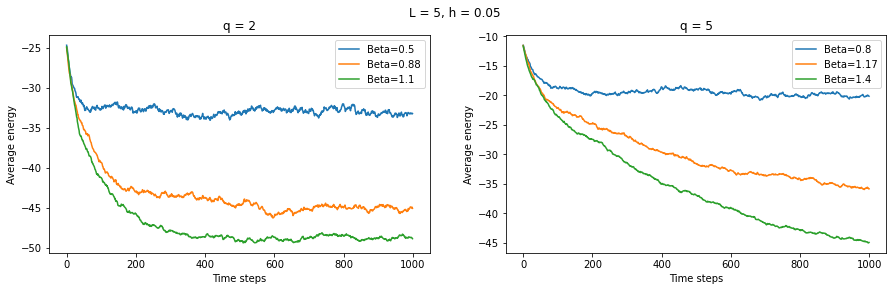

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

q2 = energy_q_list[0]
q5 = energy_q_list[1]

beta_q2 = [0.5, 0.88, 1.1]
beta_q5 = [0.8, 1.17, 1.4]
for i in range(len(beta_q2)):
    ax[0].plot(q2[i], label="Beta={}".format(beta_q2[i]))
    ax[1].plot(q5[i], label="Beta={}".format(beta_q5[i]))
    
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Average energy')

ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Average energy')

ax[0].legend()
ax[1].legend()

ax[0].set_title('q = 2')
ax[1].set_title('q = 5')
plt.suptitle('L = 5, h = 0.05')
plt.show()

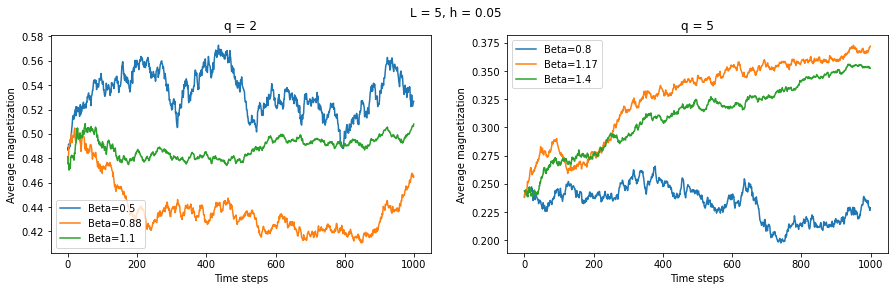

In [44]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

q2 = magnetization_q_list[0]
q5 = magnetization_q_list[1]

beta_q2 = [0.5, 0.88, 1.1]
beta_q5 = [0.8, 1.17, 1.4]
for i in range(len(beta_q2)):
    ax[0].plot(q2[i], label="Beta={}".format(beta_q2[i]))
    ax[1].plot(q5[i], label="Beta={}".format(beta_q5[i]))
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Average magnetization')

ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Average magnetization')

ax[0].legend()
ax[1].legend()

ax[0].set_title('q = 2')
ax[1].set_title('q = 5')
plt.suptitle('L = 5, h = 0.05')
plt.show()

reference for potts model

In [60]:
def magnet_autocorrelation(q, L, beta, coupling_const, ext_field, burn_in_time, max_corr_time, n_realizations):
    # Init the magnetiz product, the first and the second moments
    prod = np.zeros(max_corr_time)
    average_at_start = 0
    average_at_next = np.zeros(max_corr_time)
    sec_moment_at_start = 0
    sec_moment_at_next = np.zeros(max_corr_time)

    for i in range(n_realizations):

        # Equilibration
        state = state_generator(q, L)
        for j in range(burn_in_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)

        # The start value of the magetization is computed after the burn-in period.
        start_magnet = magneti
        average_at_start += start_magnet / n_realizations
        sec_moment_at_start += start_magnet * start_magnet / n_realizations

        # Storing the value of all the magnetizations after the burn-in
        traj = np.array([])
        for k in range(burn_in_time, burn_in_time + max_corr_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)
            traj = np.append(traj, magnetization(state))
        # Computing the statistical variables 
        prod += start_magnet * traj / n_realizations
        average_at_next += traj / n_realizations
        sec_moment_at_next += traj*traj / n_realizations

    std_start = np.sqrt(sec_moment_at_start - average_at_start**2)
    std_next = np.sqrt(sec_moment_at_next - average_at_next**2)
    return (prod - average_at_next*average_at_start) / std_start / std_next

In [71]:
%%time
L = 5
coupling_const = 1
ext_field = 0.5
burn_in_time = 10
max_corr_time = 10
n_realizations = 10

dict_q = {2: [0.5, 0.88, 1.1], 5: [0.8, 1.17, 1.4]}\

magnet_autocorr_list = []
for q, beta_list in dict_q.items():
    #iterate over the different values of q
    autocorr_trajs = []
    print('q', q)
    for beta in beta_list:
        #for each q, iterate over the 3 beta critical       
        magnet_autocorr = magnet_autocorrelation(q, L, beta, coupling_const, ext_field, burn_in_time, max_corr_time, n_realizations)
        print(magnet_autocorr)
        autocorr_trajs.append(magnet_autocorr)
    
    magnet_autocorr_list.append(autocorr_trajs)

q 2
[0.97383556 0.91855865 0.90039626 0.90974895 0.88003378 0.8965909
 0.90245335 0.87112162 0.8620109  0.87156547]
[0.983915   0.94246762 0.94958583 0.94009197 0.94023008 0.92135337
 0.91779072 0.88298752 0.85872375 0.85741754]
[0.99459357 0.99496352 0.99157304 0.98867284 0.98992806 0.97675295
 0.96974465 0.97284606 0.97485231 0.9687348 ]
q 5
[0.93624531 0.91796139 0.90660975 0.88135276 0.80127138 0.81537886
 0.80218063 0.81181365 0.77348805 0.74013299]
[0.99274099 0.98181723 0.92006215 0.87687228 0.87687228 0.83209321
 0.79117798 0.73520918 0.74663289 0.73547879]
[0.99226265 0.97164277 0.97164277 0.92402065 0.78395629 0.78045868
 0.69308798 0.68477202 0.74357075 0.74788129]
Wall time: 856 ms


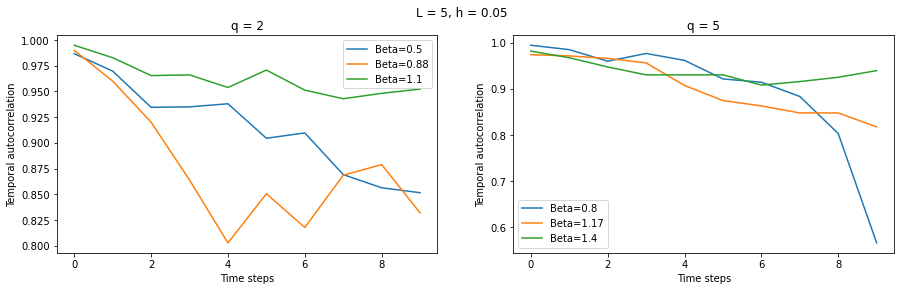

In [69]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

q2 = magnet_autocorr_list[0]
q5 = magnet_autocorr_list[1]

beta_q2 = [0.5, 0.88, 1.1]
beta_q5 = [0.8, 1.17, 1.4]
for i in range(len(beta_q2)):
    ax[0].plot(q2[i], label="Beta={}".format(beta_q2[i]))
    ax[1].plot(q5[i], label="Beta={}".format(beta_q5[i]))
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Temporal autocorrelation')

ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Temporal autocorrelation')

ax[0].legend()
ax[1].legend()

ax[0].set_title('q = 2')
ax[1].set_title('q = 5')
plt.suptitle('L = 5, h = 0.05')
plt.show()

In [54]:
def magnet_autocorrelation(q, L, beta, coupling_const, ext_field, burn_in_time, max_corr_time, n_realizations):

    # Init the magnetization product, the first and the second moments
    prod = np.zeros(max_corr_time)
    average_at_start = 0
    average_at_next = np.zeros(max_corr_time)
    sec_moment_at_start = 0
    sec_moment_at_next = np.zeros(max_corr_time)

    for i in range(n_realizations):

        # Equilibration
        state = state_generator(q, L)
        for j in range(burn_in_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)

        # The start value of the magetization is computed after the burn-in period.
        start_magnet = magnetization(state)
        average_at_start += start_magnet / n_realizations
        sec_moment_at_start += start_magnet * start_magnet / n_realizations

        # Storing the value of all the magnetizations after the burn-in
        traj = np.array([])
        for k in range(burn_in_time, burn_in_time + max_corr_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)
            traj = np.append(traj, magnetization(state))
        # Computing the statistical variables 
        prod += start_magnet * traj / n_realizations
        average_at_next += traj / n_realizations
        sec_moment_at_next += traj*traj / n_realizations

    std_start = np.sqrt(sec_moment_at_start - average_at_start**2)
    std_next = np.sqrt(sec_moment_at_next - average_at_next**2)
    return (prod - average_at_next*average_at_start) / std_start / std_next

def energy_autocorrelation(q, L, beta, coupling_const, ext_field, burn_in_time, max_corr_time, n_realizations):

    # Init the energy product, the first and the second moments
    prod = np.zeros(max_corr_time)
    average_at_start = 0
    average_at_next = np.zeros(max_corr_time)
    sec_moment_at_start = 0
    sec_moment_at_next = np.zeros(max_corr_time)

    for i in range(n_realizations):

        # Equilibration
        state = state_generator(q, L)
        for j in range(burn_in_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)

        # The start value of the energy is computed after the burn-in period.
        start_energy = energy(state, coupling_const, ext_field)
        average_at_start += start_energy / n_realizations
        sec_moment_at_start += start_energy * start_energy / n_realizations

        # Storing the value of all the energy after the burn-in
        traj = np.array([])
        for k in range(burn_in_time, burn_in_time + max_corr_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)
            traj = np.append(traj, energy(state, coupling_const, ext_field))
        # Computing the statistical variables 
        prod += start_energy * traj / n_realizations
        average_at_next += traj / n_realizations
        sec_moment_at_next += traj*traj / n_realizations

    std_start = np.sqrt(sec_moment_at_start - average_at_start**2)
    std_next = np.sqrt(sec_moment_at_next - average_at_next**2)
    return (prod - average_at_next*average_at_start) / std_start / std_next

TypeError: can't multiply sequence by non-int of type 'float'

In [7]:
max_corr_time = 2000
n_realizations = 100
q_list = [2, 5]
burn_in_time_list = [250, 1000]
beta = 0.2

a_list = []
b_list = []
for q, bit in zip(q_list, burn_in_time_list):
    print(q)
    a = [q+3*bit]
    b = q+4*bit
    print(bit)
    a_list.append(a)
    b_list.append(b)
    #iterate over the different values of q

2
250
5
1000


In [8]:
a_list

[[752], [3005]]

In [ ]:
%%time
L = 5
coupling_const = 1
ext_field = 0.05
max_corr_time = 2000
n_realizations = 100
q_list = [2, 5]
burn_in_time_list = [250, 1000]
beta = 0.2

magnet_autocorr_list = []
energy_autocorr_list = []
for q, bit in zip(q_list, burn_in_time_list):
    #for each q, iterate over the 3 beta critical       
    magnet_autocorr = magnet_autocorrelation(q, L, beta, coupling_const, ext_field, burn_in_time, max_corr_time, n_realizations)              
    energy_autocorr = energy_autocorrelation(q, L, beta, coupling_const, ext_field, burn_in_time, max_corr_time, n_realizations)

    magnet_autocorr_list.append(magnet_autocorr)
    energy_autocorr_list.append(energy_autocorr)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

q2 = magnet_autocorr_list[0]
q5 = magnet_autocorr_list[1]

ax[0].plot(q2, label = 'q = 2')
ax[1].plot(q5, label = 'q = 5')
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Temporal autocorrelation')

ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Temporal autocorrelation')

ax[0].legend()
ax[1].legend()
plt.suptitle('Magnetization \n L = 5, h = 0.05')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

q2 = energy_autocorr_list[0]
q5 = energy_autocorr_list[1]

ax[0].plot(q2, label = 'q = 2')
ax[1].plot(q5, label = 'q = 5')
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Temporal autocorrelation')

ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Temporal autocorrelation')

ax[0].legend()
ax[1].legend()

plt.suptitle('Energy \n L = 5, h = 0.05')
plt.show()

In [ ]:
def compute_error(energy_q_list, burn_in_time, correlation_time):
    q2 = energy_q_list[0]
    q5 = energy_q_list[1]

    final_error = []
    for q in [q2, q5]:
        error_for_beta = []
        for i in range(len(q)):
            beta_for_each_q = q[i]
            burn_in_period = beta_for_each_q[0:burn_in_time]
            after_burn_in = beta_for_each_q[burn_in_time:]
            final_after_burn_in = after_burn_in[0::correlation_time]
            n_corr_samples = len(final_after_burn_in)
            error = np.std(final_after_burn_in)/n_corr_samples
            error_for_beta.append(q)
        final_error.append(error_for_beta)
    return final_error

In [ ]:
burn_in_time = 
correlation_time = 
energy_error = compute_error(energy_q_list)

beta_q2 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
beta_q5 = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

fig, ax = plt.subplots(1,2,figsize=(1,2))
x_q2 = beta_q2
y_q2 = q2_energy_list
yerr_q2 = energy_error[0]
ax[0].errorbar(x_q2,y_q2,yerr_q2)

x_q5 = beta_q5
y_q5 = q5_energy_list
yerr_q5 = energy_error[1]
ax[1].errorbar(x_q5,y_q5,yerr_q5)


ax[0].set_xlabel('beta')
ax[0].set_ylabel('Average energy')
ax[1].set_xlabel('beta')
ax[1].set_ylabel('Average energy')

ax[0].legend()
ax[1].legend()

ax[0].set_title('q = 2')
ax[1].set_title('q = 5')
plt.suptitle('L = 5, h = 0.05')
plt.show()

In [ ]:
burn_in_time = 
correlation_time = 
magnetization_error = compute_error(magnetization_q_list)

beta_q2 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
beta_q5 = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

fig, ax = plt.subplots(1,2,figsize=(1,2))
x_q2 = beta_q2
y_q2 = q2_magnetization_list
yerr_q2 = magnetization_error[0]
ax[0].errorbar(x_q2,y_q2,yerr_q2)

x_q5 = beta_q5
y_q5 = q5_magnetization_list
yerr_q5 = magnetization_error[1]
ax[1].errorbar(x_q5,y_q5,yerr_q5)


ax[0].set_xlabel('beta')
ax[0].set_ylabel('Average magnetization')
ax[1].set_xlabel('beta')
ax[1].set_ylabel('Average magnetization')

ax[0].legend()
ax[1].legend()

ax[0].set_title('q = 2')
ax[1].set_title('q = 5')
plt.suptitle('L = 5, h = 0.05')
plt.show()

In [ ]:
energy_error = compute_error(energy_q_list)
magnetization_error = compute_error(magnetization_q_list)



In [ ]:
burn_in_time = 3
correlation_time = 2

q2 = energy_q_list[0]
q5 = energy_q_list[1]

final_error = []
for q in [q2, q5]:
    error_for_beta = []
    for i in range(len(q)):
        beta_for_each_q = q[i]
        burn_in_period = beta_for_each_q[0:burn_in_time]
        after_burn_in = beta_for_each_q[burn_in_time:]
        final_after_burn_in = after_burn_in[0::correlation_time]
        n_corr_samples = len(final_after_burn_in)
        error = np.std(final_after_burn_in)/n_corr_samples
        error_for_beta.append(q)
    final_error.append(error_for_beta)

In [ ]:
plt.errorbar()

In [21]:
import numpy as np

In [30]:
q34 = [1,2,3,4,5,6,7,8]
q45 = [2,3,4,5,6,7,8,9]
for i,j in zip(range(len(q34)), [q34,q45]):
    print(i)
    print(j)

0
[1, 2, 3, 4, 5, 6, 7, 8]
1
[2, 3, 4, 5, 6, 7, 8, 9]


In [22]:
q34 = [1,2,3,4,5,6,7,8]

burn_in_period = q34[0:burn_in_time]
after_burn_in = q34[burn_in_time:]
final_after_burn_in = after_burn_in[0::correlation_time]
n_corr_samples = len(final_after_burn_in)
error = np.std(final_after_burn_in)/n_corr_samples

In [23]:
burn_in_period

[1, 2, 3]

In [24]:
after_burn_in

[4, 5, 6, 7, 8]

In [25]:
final_after_burn_in

[4, 6, 8]

In [26]:
n_corr_samples

3

In [28]:
np.std(final_after_burn_in)

1.632993161855452

In [27]:
error

0.5443310539518174

In [ ]:
# %%time
# L = 5
# q = 2
# coupling_const = 1
# ext_field = 0.05
# beta = 0.5
# max_time = 1000
# n_realizations = 100

# state = state_generator(q, L)

# one_traj = energy_trajectories(state, q, coupling_const, ext_field, beta, max_time)
# ave_traj = average_energy_trajectories(state, q, coupling_const, ext_field, beta, max_time, n_realizations)

# plt.xlabel('Time steps')
# plt.ylabel('Energy')
# plt.plot(one_traj, label='Single trajectory')
# plt.plot(ave_traj, label='Average')
# plt.legend()
# plt.show()